# Fu Ice Optical Parameterization (v1a)

## Setting up LUT

Here, we are creating look-up-tables (LUT) for optical properties such as extinction coefficients, single scatter albedo $\omega_0$ and assymetry parameter $g$ for ice cloud parameter ranges used in Test 1 (Altitude/Temperature):

* Ice Mass Mixing ratio $q_i$ $\left[\frac{\text{kg of ice}}{\text{kg of air}}\right]$ range: 

$$q_i = \left(\text{0.04 to 0.11} \; \left[\frac{\text{g of ice}}{\text{kg of air}}\right]\right) \; \times \; 0.001 \; \left[\frac{\text{kg of ice}}{\text{g of ice}}\right]$$

* Ice Water Content IWC ($g$ $m^{-3}$) (We're using an average density of 0.3 $kg$ $m^{-3}$ between 10 km and 15 km):

$$IWC = q_i \left[\frac{\text{kg of ice}}{\text{kg of air}}\right] * 1000 \left[\frac{\text{g of ice}}{\text{kg of ice}}\right] * 0.3 \left[\frac{\text{kg of air}}{m^3}\right]$$

* Ice Water Path IWP ($g/m^2$) range: 0.1 to 300.1 $g/m^2$

* Fixed Effective Radius $r_e (\mu m)$ (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib notebook

# Fu Scheme (Fu 1996 and Fu, Yang and Sun 1998)

In [2]:
# This seems to be the one used in ecRad calculations:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'fu_ice_scattering_rrtm.nc'
#fu_scatt  = xr.open_dataset(data_path+file, drop_variables='siglay')
fu_scatt = nc.Dataset(data_path+file)

# What is this? Where is this parameterization used? What's the reference?:
file    = 'fu-muskatel-rough_ice_scattering.nc'
fu_musk = xr.open_dataset(data_path+file)

In [3]:
fu_scatt

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    comment: This file provides a parameterization of ice particle scattering in the longwave and shortwave RRTM bands,
using the formulation of Fu (J. Climate, 1996, 9, 2058-2082) in the shortwave and
Fu et al. (J. Climate, 1998, 11, 2223-2237) in the longwave. If De is Fu's ice effective
size (microns), and the 1-based arrays of coefficients are denoted p, then in the shortwave:
  mass extinction coefficient (m2/g) = p[1] + p[2]/De,
  single scattering albedo = 1 - (p[3] + p[4]*De + p[5]*De^2 + p[6]*De^3), and
  asymmetry factor = p[7] + p[8]*De + p[9]*De^2 + p[10]*De^3,
and in the longwave:
  mass extinction coefficient (m2/g) = p[1] + p[2]/De + p[3]/De^2,
  mass absorption coefficient (m2/g) = p[4]/De + p[5] + p[6]*De + p[7]*De^2, and
  asymmetry factor = p[8] + p[9]*De + p[10]*De^2 + p[11]*De^3,
where here mass extinction/absorption coefficient is the total extinction/absorption cross 

In [4]:
# SHORTWAVE
# Lower bound wavenumber (cm-1) for shortwave band. See Tables 3.a, b and c in Fu (1996)
# This one corresponds to middle wavenumber between band limit showed in table.
fu_sw_wn1 = fu_scatt.variables['wavenumber1_sw'][:]
fu_sw_wl1 = 1e4 / fu_sw_wn1 # (um)

# Upper bound wavenumber (cm-1) for shortwave band. See Tables 3.a, b and c in Fu (1996)
fu_sw_wn2 = fu_scatt.variables['wavenumber2_sw'][:]
fu_sw_wl2 = 1e4 / fu_sw_wn2 # (um)

# Shorwave Coefficients (10 coefficients in total (See eqns. 3.9a to c in Fu (1996))):
fu_sw_coeff = fu_scatt.variables['coeff_sw'][:]


# LONGWAVE
# Lower bound wavenumber (cm-1) for longwave band. See Tables 
fu_lw_wn1 = fu_scatt.variables['wavenumber1_lw'][:]
fu_lw_wl1 = 1e4/fu_lw_wn1 # (um)
# This one corresponds to middle wavenumber between band limit showed in table

# Upper bound wavenumber (cm-1) for longwave band. See Tables
fu_lw_wn2 = fu_scatt.variables['wavenumber2_lw'][:]
fu_lw_wl2 = 1e4 / fu_lw_wn2 # (um)

# Longwave Coefficients:
fu_lw_coeff = fu_scatt.variables['coeff_lw'][:]

In [5]:
# Pandas DataFrame for visualization:

# SW:
fu_sw_band_lim    = []
fu_sw_band_lim_cm = []
for wl in range(len(fu_sw_wl1)):
    wl2_str = str(fu_sw_wl2[wl].round(3))
    wl1_str = str(fu_sw_wl1[wl].round(3))
    wn2_str = str(int(fu_sw_wn2[wl]))
    wn1_str = str(int(fu_sw_wn1[wl]))
    fu_sw_band_lim.append(wl2_str + ' - ' + wl1_str)
    fu_sw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
fu_sw_tables = pd.DataFrame({'Band limits (um)': fu_sw_band_lim,
                             'Band limits (cm-1)': fu_sw_band_lim_cm,
                             'a0': fu_sw_coeff[:,0],
                             'a1': fu_sw_coeff[:,1],
                             'b0': fu_sw_coeff[:,2],
                             'b1': fu_sw_coeff[:,3],
                             'b2': fu_sw_coeff[:,4],
                             'b3': fu_sw_coeff[:,5],
                             'c0': fu_sw_coeff[:,6],
                             'c1': fu_sw_coeff[:,7],
                             'c2': fu_sw_coeff[:,8],
                             'c3': fu_sw_coeff[:,9]
                            })
fu_sw_tables = fu_sw_tables.set_index('Band limits (um)')

# LW:
fu_lw_band_lim = []
fu_lw_band_lim_cm = []
for wn in range(len(fu_lw_wn1)):
    wl2_str = str(fu_lw_wl2[wn].round(3))
    wl1_str = str(fu_lw_wl1[wn].round(3))
    wn2_str = str(int(fu_lw_wn2[wn]))
    wn1_str = str(int(fu_lw_wn1[wn]))
    fu_lw_band_lim.append(wl2_str + ' - ' + wl1_str)
    fu_lw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
fu_lw_tables = pd.DataFrame({'Band limits (um)': fu_lw_band_lim,
                             'Band limits (cm-1)': fu_lw_band_lim_cm,
                             'a0': fu_lw_coeff[:,0],
                             'a1': fu_lw_coeff[:,1],
                             'a2': fu_lw_coeff[:,2],
                             'b0': fu_lw_coeff[:,3],
                             'b1': fu_lw_coeff[:,4],
                             'b2': fu_lw_coeff[:,5],
                             'b3': fu_lw_coeff[:,6],
                             'c0': fu_lw_coeff[:,7],
                             'c1': fu_lw_coeff[:,8],
                             'c2': fu_lw_coeff[:,9],
                             'c3': fu_lw_coeff[:,10]
                            })
fu_lw_tables = fu_lw_tables.set_index('Band limits (um)')

## Computing Optical Properties with Fu 1996 (Shortwave)

1. Extinction Coefficients:

    1.1 Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:
    
    $$K_{ext} = K_{ext}(D_{ge}, \lambda)$$
    $$K_{ext} = a_0(\lambda) + ( a_1(\lambda) / D_{ge} )$$
    
    1.2 Extinction Coefficient $\beta_{ext}$ $(m^{-1})$:
    
    $$\beta_{ext} = \beta_{ext}(IWC, D_{ge}, \lambda)$$
    $$\beta_{ext} = IWC\times K_{ext}$$
    
    1.3 Mass Absoprtion Coefficient $m^2/g$:
    
    1.4 Optical Depth (Used by Hogan's code):
    
    $$\tau = \tau(IWP, D_{ge}, \lambda)$$
    $$\tau_{ext} = IWP\times K_{ext}$$
    
2. Single Scattering Albedo $\omega$:

    $$\omega = \omega(D_{ge}, \lambda)$$
    $$\omega = 1 - b_0(\lambda) + b_1(\lambda) D_{ge} + b_2(\lambda) D_{ge}^2 + b_3(\lambda) D_{ge}^3$$
    
3. Asymetry Factor $g$:

    $$ g = g(D_{ge}, \lambda)$$
    $$ g = c_0(\lambda) + c_1(\lambda) D_{ge} + c_2(\lambda) D_{ge}^2 + c_3 (\lambda) D_{ge}^3 $$

In [6]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
fu_sw_tables

Band limits (cm-1)            a0           a1            b0  \
Band limits (um)                                                               
3.077 - 3.846           2600 - 3250  1.875980e-04 2.513960e+00  1.967930e-01   
2.5 - 3.077             3250 - 4000  2.972950e-04 2.488950e+00  4.644160e-01   
2.151 - 2.5             4000 - 4650  4.894770e-04 2.487760e+00  5.834690e-04   
1.942 - 2.151           4650 - 5150 -8.373250e-06 2.525040e+00  2.532340e-03   
1.626 - 1.942           5150 - 6150 -8.373250e-06 2.525040e+00  2.532340e-03   
1.299 - 1.626           6150 - 7700 -8.051550e-04 2.576000e+00 -2.855180e-05   
1.242 - 1.299           7700 - 8050  6.516590e-05 2.516600e+00 -1.480120e-07   
0.778 - 1.242          8050 - 12850  8.104430e-05 2.516190e+00 -1.579630e-07   
0.625 - 0.778         12850 - 16000  1.619830e-04 2.507460e+00 -7.780010e-08   
0.442 - 0.625         16000 - 22650 -9.454580e-05 2.520610e+00  5.084470e-07   
0.345 - 0.442         22650 - 29000 -2.588580e-04 2.538150e+00 -1.985290e-07   
0.263 - 0.345         29000 - 38000 -2.669550e-04 2.541790e+00 -1.005700e-07   
0.2 - 0.263           38000 - 50000 -2.364470e-04 2.538170e+00 -2.699160e-07   
3.846 - 12.195           820 - 2600 -2.548230e-04 2.529090e+00  2.601550e-01   

                           b1            b2            b3           c0  \
Band limits (um)                                                         
3.077 - 3.846    5.752350e-03 -5.292200e-05  1.766180e-07 7.591830e-01   
2.5 - 3.077      2.047160e-05 -4.603750e-07  2.031980e-09 9.195990e-01   
2.151 - 2.5      1.181270e-03 -3.400110e-06  8.785490e-09 7.759160e-01   
1.942 - 2.151    1.750780e-03 -8.009940e-06  2.313090e-08 7.587480e-01   
1.626 - 1.942    1.750780e-03 -8.009940e-06  2.313090e-08 7.587480e-01   
1.299 - 1.626    1.719930e-03 -7.436970e-06  2.096470e-08 7.525280e-01   
1.242 - 1.299    9.023550e-05 -1.981900e-08  4.019140e-11 7.512770e-01   
0.778 - 1.242    1.724750e-06  9.021560e-11 -3.794230e-13 7.523180e-01   
0.625 - 0.778    2.533600e-07 -1.154890e-10  4.650840e-13 7.496930e-01   
0.442 - 0.625    2.732060e-08  4.965530e-11 -1.860010e-13 7.498560e-01   
0.345 - 0.442    9.394800e-08 -2.545400e-10  1.108760e-12 7.435460e-01   
0.263 - 0.345    1.604410e-07 -2.056630e-10  8.885950e-13 7.378090e-01   
0.2 - 0.263      2.129090e-07 -2.653970e-10  1.129830e-12 7.332600e-01   
3.846 - 12.195   5.455470e-03 -5.587600e-05  1.970860e-07 7.990840e-01   

                           c1            c2            c3  
Band limits (um)                                           
3.077 - 3.846    4.937650e-03 -4.840590e-05  1.658010e-07  
2.5 - 3.077      5.030250e-04 -5.747710e-06  2.017310e-08  
2.151 - 2.5      1.745170e-03 -9.213140e-06  2.150030e-08  
1.942 - 2.151    2.027090e-03 -1.170290e-05  2.951950e-08  
1.626 - 1.942    2.027090e-03 -1.170290e-05  2.951950e-08  
1.299 - 1.626    1.957480e-03 -1.024950e-05  2.354790e-08  
1.242 - 1.299    1.298240e-03 -4.990750e-06  6.337570e-09  
0.778 - 1.242    1.042240e-03 -2.266180e-06 -3.682830e-09  
0.625 - 0.778    1.054460e-03 -2.325760e-06 -3.583070e-09  
0.442 - 0.625    8.891610e-04 -3.495780e-07  1.099130e-08  
0.345 - 0.442    9.086740e-04 -4.653260e-07 -1.057860e-08  
0.263 - 0.345    8.975150e-04 -2.170990e-07 -1.160900e-08  
0.2 - 0.263      9.183170e-04 -4.229740e-07 -1.079760e-08  
3.846 - 12.195   4.817060e-03 -5.132200e-05  1.844200e-07

NOTE: There is a line repeated in the parameterization.

Possible explanation: I think Robin tried to transfer the parameterization from the bands given in Fu 1996, 1998 into the new bands used in ecRad. ecRad and other new radiative transfer models such as RRTM use more bands. For new bands not included in original parameterizations, the new rad transfer models just repeat the coefficient parameters from the next band.

In [7]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001

# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3

# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)

# Ice Water Path (g m-2):
iwp = np.arange(0.1, 300.1, 0.1)

# Effective Diameter (um)
D_ge = r_e/0.64952 # See definition of de_um in radiation_ice_optics_fu.F90 


# Extinction Coefficients (m-1)
fu_sw_b_ext = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))
# Mass Extinction Coefficient (m2/g) (See Comments in fu_ice_scattering_rrtm.nc)
fu_sw_K_ext = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))
# Mass Absorption Coefficient (m2/g) (See Comments in fu_ice_scattering_rrtm.nc)
fu_sw_K_abs = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))
# Optical Depth (Following Hogan equations in "radiation_ice_optics_fu.F90"):
fu_sw_tau   = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))

# Single Scatter Albedo:
fu_sw_ssa     = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))
# Scattering Optical Depth (Following Hogan equations in "radiation_ice_optics_fu.F90"):
fu_sw_scat_od = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))

# Asymmetry Factor:
fu_sw_g = np.zeros((len(fu_sw_wn1), len(D_ge), len(q_i)))

for wn_ix in range(len(fu_sw_wn1)):
    a0 = fu_sw_coeff[wn_ix, 0] # Coefficient a0
    a1 = fu_sw_coeff[wn_ix, 1] # Coefficient a1
    b0 = fu_sw_coeff[wn_ix, 2] # Coefficient b0
    b1 = fu_sw_coeff[wn_ix, 3] # Coefficient b1
    b2 = fu_sw_coeff[wn_ix, 4] # Coefficient b2
    b3 = fu_sw_coeff[wn_ix, 5] # Coefficient b3
    c0 = fu_sw_coeff[wn_ix, 6] # Coefficient c0
    c1 = fu_sw_coeff[wn_ix, 7] # Coefficient c1
    c2 = fu_sw_coeff[wn_ix, 8] # Coefficient c2
    c3 = fu_sw_coeff[wn_ix, 9] # Coefficient c3
    for d_ix in range(len(D_ge)):
        d_i = D_ge[d_ix]
        for iwc_ix in range(len(iwc)):
            iwc_i = iwc[iwc_ix]
            iwp_i = iwp[iwc_ix] # Adjusted to be same length than Ice Water Content
            
            # Extinction coefficient (m-1) from Eq. 3.9a of Fu 1996:
            b_ext_i = iwc_i * (a0 + ( a1 / d_i )) 
            fu_sw_b_ext[wn_ix, d_ix, iwc_ix] = b_ext_i
            
            # Mass Extinction Coefficient (m2/g) (See Comments in fu_ice_scattering_rrtm.nc):
            K_ext_i = a0 + ( a1 / d_i )
            fu_sw_K_ext[wn_ix, d_ix, iwc_ix] = K_ext_i            
            
            # Optical Depth from Eq. in "radiation_ice_optics_fu.F90" by Hogan:
            tau_i   = iwp_i * (a0 + ( a1 / d_i ))
            fu_sw_tau[wn_ix, d_ix, iwc_ix] = tau_i
            
            
            # Single Scatter Albedo from Eq. 3.9b of Fu 1996:
            ssa_i   = 1 - (b0 + b1*d_i + b2*d_i**2 + b3*d_i**3)
            fu_sw_ssa[wn_ix, d_ix, iwc_ix] = ssa_i
            
            # Scattering Optical Depth from Eq. in "radiation_ice_optics_fu.F90" by Hogan:
            #scat_od_i = od_i*(1 - b0 + b1*d_i + b2*d_i**2 + b3*d_i**3)
            #fu_sw_scat_od[wn_ix, d_ix, iwc_ix] = scat_od_i
            
            
            # Mass Absorption Coefficient (m2/g) (as Kext(1-w)):
            K_abs_i = K_ext_i*(1 - ssa_i)
            fu_sw_K_abs[wn_ix, d_ix, iwc_ix] = K_abs_i
            
            
            # Assymetry Parameter from Eq. 3.9c of Fu 1996
            g_i     = c0 + c1*d_i + c2*d_i**2 + c3*d_i**3 
            fu_sw_g[wn_ix, d_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Fu SW

In [8]:
fu_sw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'd_ge', 'iwc'], fu_sw_K_ext),
        K_abs = (['sw_wn_1', 'd_ge', 'iwc'], fu_sw_K_abs),
        tau   = (['sw_wn_1', 'd_ge', 'iwc'], fu_sw_tau),
        ssa   = (['sw_wn_1', 'd_ge', 'iwc'], fu_sw_ssa),
        g     = (['sw_wn_1', 'd_ge', 'iwc'], fu_sw_g),
    ),
    attrs = dict(
        title="LUT for Fu SW. Ranges for Altitude-Temperature Test."),
)

In [9]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'FuSW_test1_LUT_v1a.nc'
fu_sw.to_netcdf(path = out_dir+file)

## Computing optical properties with Fu, Yang & Sun, 1998 (Longwave)

1. Extinction Coefficients:

    1.1 Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:
    
    $$K_{ext} = K_{ext}(D_{ge}, \lambda)$$
    $$K_{ext} = a_0(\lambda) + ( a_1(\lambda) / D_{ge} )$$
    
    1.2 Extinction Coefficient $\beta$ $(m^{-1})$:
    
    $$\beta_{ext} = \beta_{ext}(IWC, D_{ge}, \lambda)$$
    $$\beta_{ext} = IWC\times K_{ext}$$
    
    1.3 Mass Absoprtion Coefficient $m^2/g$:
    
    1.4 Optical Depth (Used by Hogan's code):
    
    $$\tau = \tau(IWP, D_{ge}, \lambda)$$
    $$\tau_{ext} = IWP\times K_{ext}$$
    
2. Single Scattering Albedo $\omega$:

    $$\omega = \omega(D_{ge}, \lambda)$$
    $$\omega = 1 - b_0(\lambda) + b_1(\lambda) D_{ge} + b_2(\lambda) D_{ge}^2 + b_3(\lambda) D_{ge}^3$$
    
3. Asymetry Factor $g$:

    $$ g = g(D_{ge}, \lambda)$$
    $$ g = c_0(\lambda) + c_1(\lambda) D_{ge} + c_2(\lambda) D_{ge}^2 + c_3 (\lambda) D_{ge}^3 $$

In [10]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
fu_lw_tables

Band limits (cm-1)            a0           a1            a2  \
Band limits (um)                                                               
28.571 - 1000.0            10 - 350  4.919685e-03 2.327741e+00 -1.390858e+01   
20.0 - 28.571             350 - 500  3.325756e-03 2.601360e+00 -1.909602e+01   
15.873 - 20.0             500 - 630 -1.334860e-02 4.043808e+00 -2.171029e+01   
14.286 - 15.873           630 - 700 -9.524174e-03 3.587742e+00 -1.068895e+01   
12.195 - 14.286           700 - 820 -4.159424e-03 3.047325e+00 -5.061568e+00   
10.204 - 12.195           820 - 980 -1.691632e-03 2.765756e+00 -8.331033e+00   
9.259 - 10.204           980 - 1080 -8.372696e-03 3.455018e+00 -1.516692e+01   
8.475 - 9.259           1080 - 1180 -8.178608e-03 3.401245e+00 -8.812820e+00   
7.194 - 8.475           1180 - 1390 -4.936610e-03 3.087764e+00 -3.884262e+00   
6.757 - 7.194           1390 - 1480 -3.034573e-03 2.900043e+00 -1.849911e+00   
5.556 - 6.757           1480 - 1800 -3.034573e-03 2.900043e+00 -1.849911e+00   
4.808 - 5.556           1800 - 2080 -2.465236e-03 2.833187e+00 -4.227573e-01   
4.444 - 4.808           2080 - 2250 -2.308881e-03 2.814002e+00  1.072211e+00   
4.202 - 4.444           2250 - 2380 -2.308881e-03 2.814002e+00  1.072211e+00   
3.846 - 4.202           2380 - 2600 -2.308881e-03 2.814002e+00  1.072211e+00   
3.077 - 3.846           2600 - 3250 -2.308881e-03 2.814002e+00  1.072211e+00   

                           b0            b1            b2           b3  \
Band limits (um)                                                         
28.571 - 1000.0  8.869787e-01  2.118409e-02 -2.781429e-04 1.094562e-06   
20.0 - 28.571    2.005578e-01  2.132614e-02 -1.751052e-04 5.355885e-07   
15.873 - 20.0    3.003701e-01  2.051529e-02 -1.931684e-04 6.583031e-07   
14.286 - 15.873  9.551440e-01  1.309792e-02 -1.793694e-04 7.313392e-07   
12.195 - 14.286  1.466481e+00 -2.129226e-03 -1.361630e-05 1.193649e-07   
10.204 - 12.195  1.195515e+00  3.350616e-03 -5.266996e-05 2.233377e-07   
9.259 - 10.204   5.409536e-01  1.949649e-02 -2.050908e-04 7.364680e-07   
8.475 - 9.259    5.874323e-01  1.876628e-02 -2.045834e-04 7.510080e-07   
7.194 - 8.475    7.152274e-01  1.621734e-02 -1.868544e-04 7.078738e-07   
6.757 - 7.194    8.862434e-01  1.226538e-02 -1.523076e-04 6.000892e-07   
5.556 - 6.757    8.862434e-01  1.226538e-02 -1.523076e-04 6.000892e-07   
4.808 - 5.556    7.428957e-01  1.279601e-02 -1.391803e-04 5.180104e-07   
4.444 - 4.808    4.346482e-01  1.721457e-02 -1.623227e-04 5.561523e-07   
4.202 - 4.444    4.346482e-01  1.721457e-02 -1.623227e-04 5.561523e-07   
3.846 - 4.202    4.346482e-01  1.721457e-02 -1.623227e-04 5.561523e-07   
3.077 - 3.846    4.346482e-01  1.721457e-02 -1.623227e-04 5.561523e-07   

                           c0           c1            c2           c3  
Band limits (um)                                                       
28.571 - 1000.0  4.949276e-01 1.186174e-02  1.267629e-04 4.603574e-07  
20.0 - 28.571    6.891414e-01 6.192281e-03 -6.459514e-05 2.436963e-07  
15.873 - 20.0    7.260484e-01 2.664334e-03 -1.251136e-05 2.243377e-08  
14.286 - 15.873  7.363466e-01 4.798266e-03 -4.413293e-05 1.525774e-07  
12.195 - 14.286  7.984021e-01 3.977117e-03 -4.471984e-05 1.694919e-07  
10.204 - 12.195  8.663385e-01 2.797934e-03 -3.187011e-05 1.217209e-07  
9.259 - 10.204   8.906280e-01 1.903269e-03 -1.733552e-05 5.855071e-08  
8.475 - 9.259    8.609604e-01 2.200445e-03 -1.748105e-05 5.176616e-08  
7.194 - 8.475    8.522816e-01 2.523627e-03 -2.149196e-05 6.685067e-08  
6.757 - 7.194    8.741665e-01 2.455409e-03 -2.456935e-05 8.641223e-08  
5.556 - 6.757    8.741665e-01 2.455409e-03 -2.456935e-05 8.641223e-08  
4.808 - 5.556    8.472918e-01 2.559953e-03 -2.182660e-05 6.879977e-08  
4.444 - 4.808    7.962716e-01 3.003488e-03 -2.082376e-05 5.366545e-08  
4.202 - 4.444    7.962716e-01 3.003488e-03 -2.082376e-05 5.366545e-08  
3.846 - 4.202    7.962716e-01 3.003488e-03 -2.082376e-05 5.366545e-08  
3.077 - 3.846    7.

In [12]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
#q_i = np.arange(0.001, 3.001, 0.001)*0.001

# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
#iwc = q_i*1000*0.3

# Ice Water Path (g m-2):
#iwp = np.arange(0.1, 300.1, 0.1)

# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
#r_e  = np.arange(1, 100.1, .1)

# Effective Diameter (um):
D_ge = r_e/0.64952 # See definition of de_um in radiation_ice_optics_fu.F90


# Extinction Coefficients (m-1)
fu_lw_b_ext = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))
# Mass Extinction Coefficient (m2/g) (See Comments in fu_ice_scattering_rrtm.nc)
fu_lw_K_ext = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))
# Absorption Coefficients (m-1)
fu_lw_b_abs = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))
# Mass Absorption Coefficient (m2/g)
fu_lw_K_abs = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))

# Single Scatter Albedo:
fu_lw_ssa = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))

# Asymmetry Factor:
fu_lw_g = np.zeros((len(fu_lw_wn1), len(D_ge), len(q_i)))

for wn_ix in range(len(fu_lw_wn1)):
    a0 = fu_lw_coeff[wn_ix, 0] # Coefficient a0
    a1 = fu_lw_coeff[wn_ix, 1] # Coefficient a1
    a2 = fu_lw_coeff[wn_ix, 2] # Coefficient a2
    b0 = fu_lw_coeff[wn_ix, 3] # Coefficient b0
    b1 = fu_lw_coeff[wn_ix, 4] # Coefficient b1
    b2 = fu_lw_coeff[wn_ix, 5] # Coefficient b2
    b3 = fu_lw_coeff[wn_ix, 6] # Coefficient b3
    c0 = fu_lw_coeff[wn_ix, 7] # Coefficient c0
    c1 = fu_lw_coeff[wn_ix, 8] # Coefficient c1
    c2 = fu_lw_coeff[wn_ix, 9] # Coefficient c2
    c3 = fu_lw_coeff[wn_ix, 10] # Coefficient c3
    for d_ix in range(len(D_ge)):
        d_i = D_ge[d_ix]
        for iwc_ix in range(len(iwc)):
            iwc_i   = iwc[iwc_ix]
            
            # Extinction Coefficient (m-1):
            b_ext_i = iwc_i * (a0 + ( a1 / d_i ) + ( a2 / d_i**2 )) # Eq. 3.1 from Fu, Yang and Sun, 1998
            fu_lw_b_ext[wn_ix, d_ix, iwc_ix] = b_ext_i
            
            # Mass Extinction Coefficient (m2/g) (See Comments in fu_ice_scattering_rrtm.nc):
            K_ext_i = a0 + ( a1 / d_i ) + ( a2 / d_i**2 )
            fu_lw_K_ext[wn_ix, d_ix, iwc_ix] = K_ext_i
            
            # Absorption Coefficient (m-1):
            b_abs_i = (iwc_i / d_i) * (b0 + b1*d_i + b2*d_i**2 + b3*d_i**3) # Eq. 3.2 from Fu, Yang and Sun, 1998
            fu_lw_b_abs[wn_ix, d_ix, iwc_ix] = b_abs_i
            
            
            # Single Scattering Albedo:
            ssa_i   = 1 - (b_abs_i / b_ext_i)
            fu_lw_ssa[wn_ix, d_ix, iwc_ix] = ssa_i
            
            # Mass Absorption Coefficient (m2/g) (as Kext(1-w)):
            K_abs_i = K_ext_i*(1 - ssa_i)
            fu_lw_K_abs[wn_ix, d_ix, iwc_ix] = K_abs_i
            
            
            # Assymetry Parameter:
            g_i     = c0 + c1*d_i + c2*d_i**2 + c3*d_i**3 # Eq. 3.3 from Fu, Yang and Sun, 1998
            fu_lw_g[wn_ix, d_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Fu LW

In [12]:
fu_lw = xr.Dataset(
    data_vars = dict(
        K_ext = (['lw_wn_1', 'd_ge', 'iwc'], fu_lw_K_ext),
        K_abs = (['lw_wn_1', 'd_ge', 'iwc'], fu_lw_K_abs),
        ssa = (['lw_wn_1', 'd_ge', 'iwc'], fu_lw_ssa),
        g = (['lw_wn_1', 'd_ge', 'iwc'], fu_lw_g),
    ),
    attrs = dict(
        title="LUT for Fu LW. Ranges for Altitude-Temperature Test."),
)

In [13]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'FuLW_test1_LUT_v1a.nc'
fu_lw.to_netcdf(path = out_dir+file)

## Plotting Fu Optical parameters vs Particle Size and Wavelength

ALL BANDS and full size range

<IPython.core.display.Javascript object>


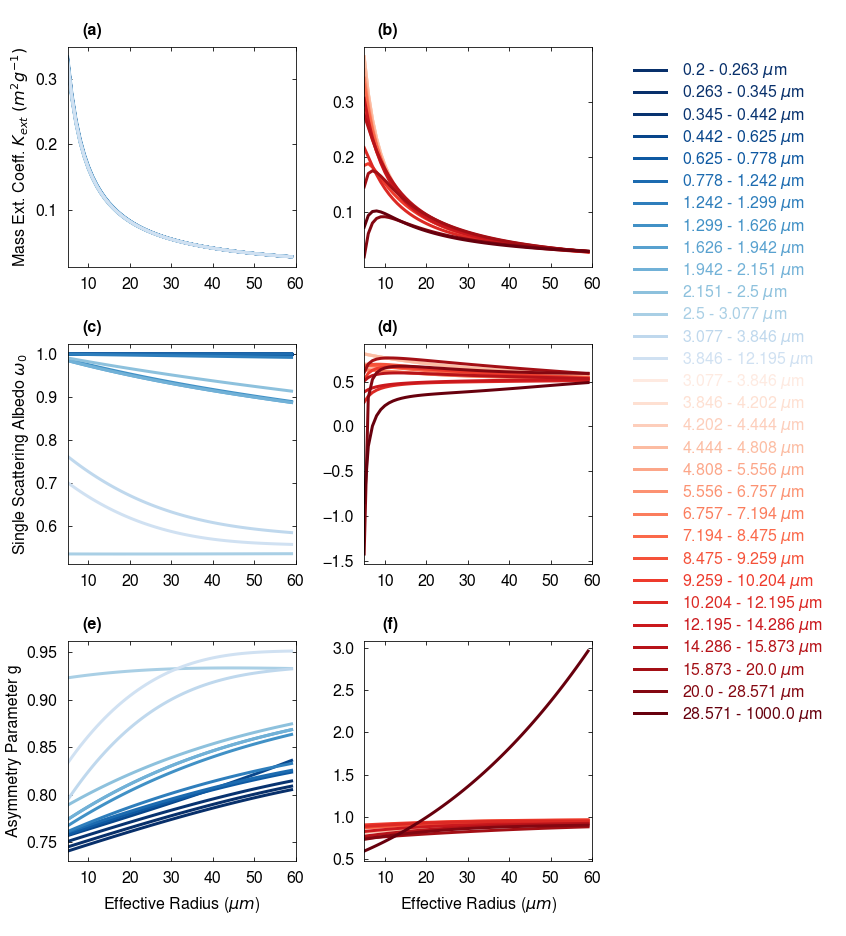

In [21]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13 # inches
flength  = 11.75 # inches


rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.08, right = 0.7, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        fu_plot = eval('fu_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) + [13] # Selected bands len(fu_plot[:,0,0])
        if rad_comp == 1: bands = list(np.arange(0,16)[::-1]) # Selected bands len(fu_plot[:,0,0])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(r_e, fu_plot[band, :, 0],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(1e4/eval('fu_'+rad_comps[rad_comp]+'_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('fu_'+rad_comps[rad_comp]+'_wn1')[band],3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('fu_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('fu_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)
               
        if opt_prop == 2:
            ax[opt_prop, rad_comp].set_xlabel(r'Effective Radius ($\mu m$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
                                           size = 4, direction = 'in', top = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].set_xlim(5, 60)
        ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        ax[opt_prop, rad_comp].tick_params(axis = 'y', which = 'major', color = 'black',
                                           size = 4, direction = 'in', right = True,
                                           labelsize = fontsize, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)

        #ax[rad_comp, opt_prop].set_yticks(yticks)
        #ax[rad_comp, opt_prop].set_yticklabels(yticklabels)
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
#             if j == 1:
#                 ax[rad_comp, opt_prop].text(0.95, 0.95, Diff_lw[diff],
#                              ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
#                              fontsize = fontsize, fontname = fontname, color = 'black')
#             ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.99, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'fu_opt_prop_all_bands_full_size_v1a.png', dpi=500)

Ploting selected bands and smaller size range. Bands 3.846-12.195 (SW) and 28.571-1000 (LW) are discarded:

<IPython.core.display.Javascript object>


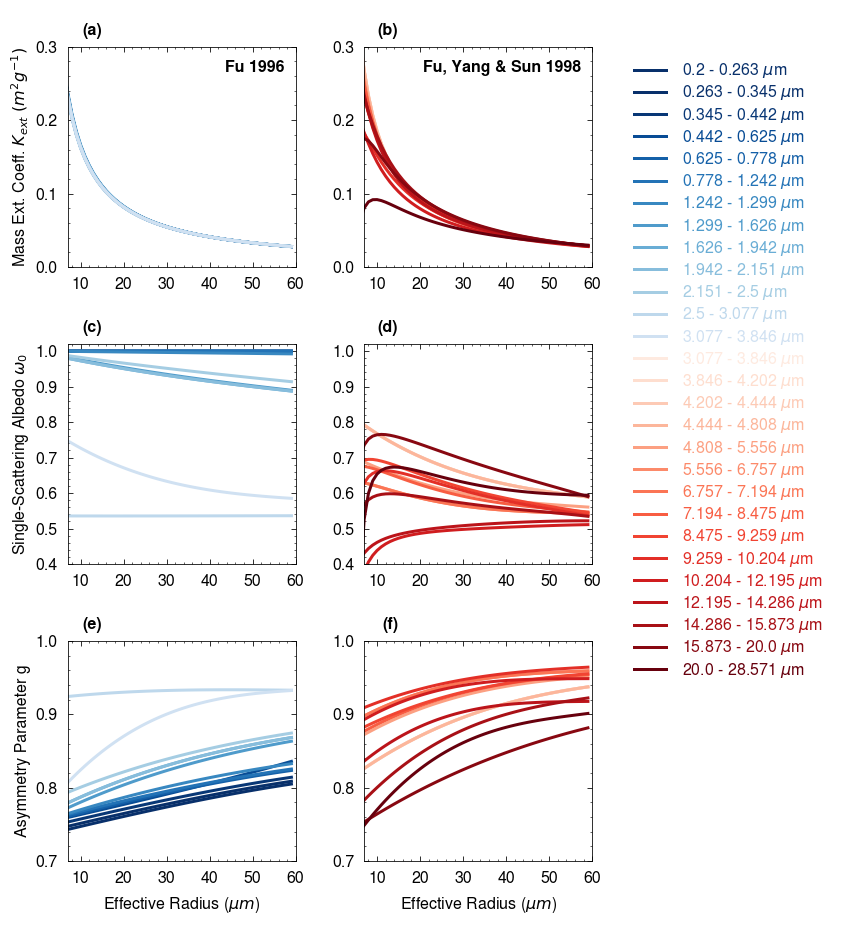

In [22]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13 # inches
flength  = 11.75 # inches


rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.08, right = 0.7, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single-Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        fu_plot = eval('fu_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) # Selected bands len(fu_plot[:,0,0])
        if rad_comp == 1: bands = list(np.arange(1,16)[::-1]) # Selected bands len(fu_plot[:,0,0])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(r_e, fu_plot[band, :, 0],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            label = (str(round(1e4/eval('fu_'+rad_comps[rad_comp]+'_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('fu_'+rad_comps[rad_comp]+'_wn1')[band],3)) + r' $\mu$m')
            labels.append(label)
        
        # X Axis:
        if opt_prop == 2:
            ax[opt_prop, rad_comp].set_xlabel(r'Effective Radius ($\mu m$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(7, 60)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
#                                            size = 5, direction = 'in', top = True,
#                                            labelsize = fontsize, pad = 10)
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'minor', color = 'black', 
#                                            size = 2, direction = 'in', top = True, 
#                                            labelsize = fontsize1, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        

        
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
        if opt_prop == 0: # Mass Extinction Coefficient
            ax[opt_prop, rad_comp].set_ylim(0, 0.3)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 1: # SSA
            ax[opt_prop, rad_comp].set_ylim(0.4, 1.02)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 2: # g
            ax[opt_prop, rad_comp].set_ylim(0.7, 1)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
        
# Scheme Title:
ax[0, 0].text(0.95, 0.94, 'Fu 1996', weight = 'bold',
              ha = 'right', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')
ax[0, 1].text(0.95, 0.94, 'Fu, Yang & Sun 1998', weight = 'bold',
              ha = 'right', va = 'top', transform = ax[0, 1].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')


# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.99, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'fu_opt_prop_some_bands_smaller_size_v1a.png', dpi=500)

2024-03-05: Why 2.5 to 3.077 um band has a quasi-flat ssa? See next figure. The coefficients in Hogans table are correct... but, then?

<IPython.core.display.Javascript object>


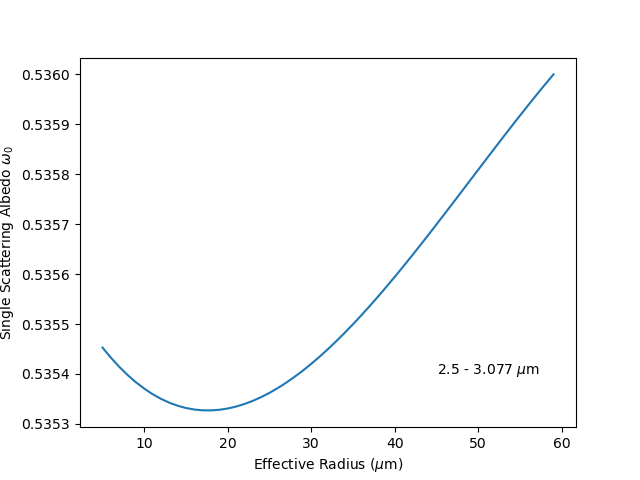

Text(45, 0.5354, '2.5 - 3.077 $\\mu$m')

In [23]:
plt.figure()
plt.plot(r_e,fu_sw_ssa[1,:,0])
plt.xlabel(r'Effective Radius ($\mu$m)')
plt.ylabel(r'Single Scattering Albedo $\omega_0$')
plt.text(45, 0.5354, r'2.5 - 3.077 $\mu$m')

Plot optical parameters vs wavelength for one size (30 um)

<IPython.core.display.Javascript object>


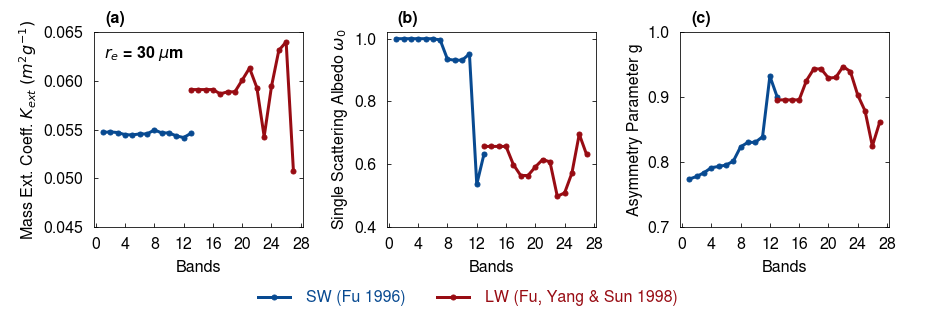

In [20]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 4.5 # inches
flength  = 13 # inches


rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.3, left = 0.1, right = 0.95, 
                    hspace = .35, wspace = .4)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

sel_size = np.where(r_e == 30)[0][0] # 30 um selected

for opt_prop in range(columns):
    fu_sw_plot = eval('fu_sw_' + opt_props[opt_prop])
    fu_lw_plot = eval('fu_lw_' + opt_props[opt_prop])
    h1 = ax[opt_prop].plot(np.arange(1,14),fu_sw_plot[:-1, sel_size, 0][::-1],
                           '.-',#linestyle = 'solid', 
                           markersize = 10,
                           linewidth = 3, color = matplotlib.cm.Blues(.9))
    h2 = ax[opt_prop].plot(np.arange(13,28),fu_lw_plot[1:, sel_size, 0][::-1],
                           '.-',#linestyle = 'solid', 
                           markersize = 10,
                           linewidth = 3, color = matplotlib.cm.Reds(.9))

    ax[opt_prop].set_xlabel('Bands', fontsize = fontsize, fontname = fontname,
                            color ='black', labelpad = 7.5)
    for tick in ax[opt_prop].get_xticklabels():
        tick.set_fontname(fontname)
    ax[opt_prop].xaxis.set_major_locator(ticker.MultipleLocator(4))

    for tick in ax[opt_prop].get_yticklabels():
        tick.set_fontname(fontname)
    opt_props_labeli = opt_props_label[opt_prop]
    ax[opt_prop].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                          fontname = fontname, color ='black', labelpad = 5)
    if opt_prop == 0: # Mass Extinction Coefficient
        ax[opt_prop].set_ylim(0.045, 0.065)
    elif opt_prop == 1: # SSA
        ax[opt_prop].set_ylim(0.4, 1.02)
    elif opt_prop == 2: # g
        ax[opt_prop].set_ylim(0.7, 1)
    
    ax[opt_prop].tick_params(axis = 'both', which = 'major', color = 'black',
                             size = 4, direction = 'in', right = True,
                             labelsize = fontsize, pad = 10)
    
    # Panel letters:
    ax[opt_prop].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                ha = 'right', va = 'top', transform = ax[opt_prop].transAxes,
                                fontsize = fontsize, fontname = fontname, color = 'black')
    panel_letters_i += 1

ax[0].text(0.05, 0.94, r'$r_e$ = 30 $\mu$m', weight = 'bold',
           ha = 'left', va = 'top', transform = ax[0].transAxes,
           fontsize = fontsize, fontname = fontname, color = 'black')
    
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2
labels  = ['SW (Fu 1996)', 'LW (Fu, Yang & Sun 1998)']
legend  = plt.legend(handles, labels, loc = 'lower center',
                     bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 2, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'fu_opt_prop_vs_bands_30um_v1a.png', dpi=500)

Wavelength bands in um are the same for each optical parameterization (Fu, Yi and Barans).

Selected bands for matrix visualization comparison:
- Position 9 of Shortwave Bands: 0.625 um (wn1) - 0.441 um (wn2)
- Position 6 of Longwave Bands: 10.2 um (wn1) - 9.259 um (wn2)